In [1]:
## standart libraries

import os,sys
import numpy as np

import timeit

# xarray
import xarray as xr
import pandas as pd
import datetime
# plot
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.colors import from_levels_and_colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.feature as cfeature

# custom tools for plotting
import lib_SLXtools_IMHOTEP_2021 as slx

# for jupyter notebook display
%matplotlib inline

import pkg_resources


In [2]:
prefix = "eORCA025.L75-IMHOTEP"
nexpREF = "GAI"
diridatref="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexpREF+"-S/"
fo='1m'

yr=1980
month='09'

filepathREF = diridatref+fo+"/"+str(yr)+"/"+prefix+"."+nexpREF+"_y"+str(yr)+"m"+month+".1m_icemod.nc"
dsmonth = xr.open_dataset(filepathREF,decode_times=False)
dsmonth

<xarray.Dataset>
Dimensions:               (y: 1207, x: 1442, time_counter: 1, axis_nbounds: 2)
Coordinates:
    nav_lat               (y, x) float32 ...
    nav_lon               (y, x) float32 ...
    time_centered         (time_counter) float64 ...
  * time_counter          (time_counter) float64 2.547e+09
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/46)
    time_centered_bounds  (time_counter, axis_nbounds) float64 ...
    time_counter_bounds   (time_counter, axis_nbounds) float64 ...
    simsk                 (time_counter, y, x) float32 ...
    simsk15               (time_counter, y, x) float32 ...
    snvolu                (time_counter, y, x) float32 ...
    snthic                (time_counter, y, x) float32 ...
    ...                    ...
    siextentn             (time_counter) float32 ...
    sivoln                (time_counter) float32 ...
    siarean               (time_counter) float32 ...
    siextents             (time_counter) float32 ...
    sivols                (time_counter) float32 ...
    siareas               (time_counter) float32 ...
Attributes:
    description:       ice variables
    title:             ice variables
    Conventions:       CF-1.6
    uuid:              0f5bb0a7-081b-48d7-b5ad-917523a1d321
    start_date:        19580101
    output_frequency:  1m
    CONFIG:            eORCA025.L75
    CASE:              IMHOTEP.GAI

In [3]:
# loading one dataset to see all variables in the ice module (40 variables)
prefix = "eORCA025.L75-IMHOTEP"
nexpREF = "GAI"
path = "/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexpREF+"-S/1y/2011/"+prefix+".GAI_y2011.1y_icemod.nc"
ds = xr.open_dataset(path,decode_times=False)
ds

<xarray.Dataset>
Dimensions:       (y: 1207, x: 1442, time_counter: 1)
Coordinates:
  * time_counter  (time_counter) float64 9.969e+36
Dimensions without coordinates: y, x
Data variables: (12/40)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    simsk         (time_counter, y, x) float32 ...
    simsk15       (time_counter, y, x) float32 ...
    snvolu        (time_counter, y, x) float32 ...
    snthic        (time_counter, y, x) float32 ...
    ...            ...
    albedo        (time_counter, y, x) float32 ...
    hfxcndbot     (time_counter, y, x) float32 ...
    hfxsensib     (time_counter, y, x) float32 ...
    sfxice        (time_counter, y, x) float32 ...
    vfxice        (time_counter, y, x) float32 ...
    vfxsnw        (time_counter, y, x) float32 ...
Attributes:
    start_date:        19580101
    output_frequency:  1m
    CONFIG:            eORCA025.L75
    CASE:              IMHOTEP.GAI

In [4]:
#ds.sivolu.plot()
dasimsk =dsmonth.siconc.where(ds.nav_lat>60,drop=False)

# Map to see sea ice volume in the Arctic
reg = 'gro'

# RUN to PLOT

#========= DATA TO PLOT
for iexp in ['nexpREF']: #'DIFFGAIAI' 'DIFFGAIS','DIFFAIS','DIFFGAIGA','DIFFGAIGI']:

    # main variable
    if iexp=='nexpREF':
        data = dasimsk
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="sea ice area fraction" #" over "+y1+"-"+y2 # SSH
        namo = "Siconc.png"
        print(namo)


    # lat lon
    lon2plot   = nav_lon.squeeze()
    lat2plot   = nav_lat.squeeze()
    # land mask from model
    m2plt      = tmask.where(tmask==0)

    #========= Plot settings ===============
    levbounds=[0.,1.05,0.05]  # varna sossheig

    # COLORMAP
    co='vi' # inferno
    #add indication of colormap to the plot name:
    #namo = co+namo

    # color for continents from data based (hi-res)
    onecohrml='#2E2E2E'

    # customed colormapls
    if (co=='in'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='inferno_r',cu='w',co='k')

    if (co=='vi'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='viridis_r',cu='w',co='r')

    if (co=='coolwarm'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='seismic',cu='midnightblue',co='darkred')

    if (co=='Spectral'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='Spectral_r',cu='w',co='r')


    # default gridlines parameters
    gridl=False
    incrgridlon=30
    incrgridlat=10


    loncentr=0
    latcentr=90
    sath=2085831


    #================================================================
    #========= CREATE FIGURE
    fig3 = plt.figure(figsize=([18,10]),facecolor='white')

    #========= PLOT DATA
    # Data system proj (if coords are in lat lon, use PlateCarre here)
    trdata  = ccrs.PlateCarree() 

    ax = plt.axes(projection= ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,
                                                       satellite_height=sath))

    cs  = plt.pcolormesh(lon2plot, lat2plot, data2plot,shading='flat',cmap=cmap,transform=trdata,norm=norm)

    # plot grey shading  where ocean mask is 0 (land gridpoints in the model)
    cs2  = plt.pcolormesh(lon2plot, lat2plot, m2plt, shading='flat',
                          transform=trdata) # cmap=slx.make_SLXcolormap(reverse=False)

    
    ##============= BATHYMETRY
    # Add 1000 and 200 meters bathymetry lines and labels. We will apply a Gaussian filter to smooth the data. 
    bathy_levels = [200,1000,2000,4000]
    color_levels= ['k','navy','mediumblue','slateblue']
    # west
    Ct1 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0),
                    bathy_levels,colors=color_levels,
                    linewidths=0.7,linestyles='solid',transform=trdata)
    # east
    Ct2 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0),
                    bathy_levels,colors=color_levels,
                    linewidths=0.7,linestyles='solid',transform=trdata)

    #========= coastlines and gridlines

    # cartopy basic options for coastlines
    #cl = ax.coastlines(color= '#BDBDBD')
    #
    # cartopy FEATURES
    rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', 
                                                 scale='50m',facecolor='none',edgecolor='b')

        #lands = cartopy.feature.NaturalEarthFeature(
        #    category='physical', name='coastline',
        #    scale='50m',facecolor='none',edgecolor='k')

    cl2 = ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor=onecohrml,edgecolor= 'none',alpha=1,zorder=5)
    clr = ax.add_feature(cartopy.feature.RIVERS,alpha=0.4,facecolor='none',edgecolor='#A9E2F3',zorder=6)
    clr2 = ax.add_feature(rivers,alpha=0.4,facecolor='none',edgecolor='#A9E2F3',zorder=6)  ##CEE3F6

    #========= GRIDLINES
    gl =ax.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
    label_style = {'size': 12, 'color': '#BDBDBD', 'weight': 'normal'}
    gl.xlabel_style = label_style
    #gl.xlabels_bottom = False
    gl.ylabel_style = label_style
    #gl.ylabels_right = False

    #========= ADD COLORBAR
    cbon=True
    if cbon:
        cb = slx.addcolorbar(fig3,cs,ax,levbounds,levincr=1,tformat="%.2f",
                            tlabel=tlabel,facmul=1,orientation='horizontal',tc='k',
                            bbta=(-0.18,-0.25,0.9,0.2))  

    #========= PLT SHOW
    plt.show()    # rgb color for model land grid points
    #slx.saveplt(fig3,diro,namo,dpifig=300)
    plt.close(fig3)

NameError: name 'tmask' is not defined

# loading data

In [5]:
prefix = "eORCA025.L75-IMHOTEP"
nexp = "S"
nexpAI = "AI"
nexpREF = "GAI"

varna = 'sivolu' 

# years to read data from:
y1=1980
y2=2018


fo="1y" # output frequency, could be "1y" or "1m"

#  input directory on store
diridatref="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexpREF+"-S/"
diridatAI="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexpAI+"-S/"
diridat="/gpfsstore/rech/cli/rcli002/eORCA025.L75/"+prefix+"."+nexp+"-S/"

# input directory on work
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"

#  input directory on MY work
dirww ="/gpfswork/rech/cli/uor98hu/myncfiles/"


# read grid files
# input directory on work
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"

# read grid files
mesh = xr.open_dataset(diri+'mesh_hgr.nc')
tmask = mesh.tmask[0,0,:,:] # grille lat/lon
nav_lon = mesh.nav_lon
nav_lat = mesh.nav_lat
e1t = mesh.e1t
e2t = mesh.e2t
mbathy = xr.open_dataset(diri+'eORCA025.L75_domain_cfg_closed_seas_greenland.nc')['bathy_meter'].isel(t=0) # grille lat/lon

In [6]:
%%time
# creating a dataset with the variable sivolu for the years over period y1-y2

# for a given simu (here S)

# new numpy matrix
# setting the dimensions: x, y t
t_dim = y2-y1+1
x_dim = 1442
y_dim = 1207
#creating the 3 matrix to obtain
sivolu_matrix = np.ones((t_dim, y_dim, x_dim))
sivolu_matrixREF = np.ones((t_dim, y_dim, x_dim))
sivolu_matrixAI = np.ones((t_dim, y_dim, x_dim))

yr_counter =0
for yr in np.arange(y1,y2+1):
    filepath = diridat+fo+"/"+str(yr)+"/"+prefix+"."+nexp+"_y"+str(yr)+".1y_icemod.nc"
    filepathREF = diridatref+fo+"/"+str(yr)+"/"+prefix+"."+nexpREF+"_y"+str(yr)+".1y_icemod.nc"
    filepathAI = diridatAI+fo+"/"+str(yr)+"/"+prefix+"."+nexpAI+"_y"+str(yr)+".1y_icemod.nc"
    
    #opening the file
    S1y = xr.open_dataset(filepath,decode_times=False)[varna]
    REF1y = xr.open_dataset(filepathREF,decode_times=False)[varna]
    AI1y = xr.open_dataset(filepathAI,decode_times=False)[varna]
    
    # Saving the yearly data in the new matrix
    sivolu_matrix[yr_counter,:,:]   = S1y.isel(time_counter=0).values
    sivolu_matrixREF[yr_counter,:,:]= REF1y.isel(time_counter=0).values
    sivolu_matrixAI[yr_counter,:,:] = AI1y.isel(time_counter=0).values
    #print(yr)
    yr_counter+=1


CPU times: user 5.78 s, sys: 1.68 s, total: 7.46 s
Wall time: 25.5 s


In [8]:
#S1y

# converting the matrixes into datarray easy to use

In [7]:
#creating the coordinates for the datarray
time = pd.date_range(start=str(y1), end=str(y2+1), freq='Y')
lats = ds.nav_lat.values
longs = ds.nav_lon.values

dasivolu = xr.DataArray(data=sivolu_matrix, dims=["time_counter","y","x"],coords=dict(
    lon=(["y", "x"], longs),
    lat=(["y", "x"], lats),
    time_counter=time),
                        attrs=dict(description="Sea-ice volume per area",units="m"))

dasivoluREF = xr.DataArray(data=sivolu_matrixREF, dims=["time_counter","y","x"],coords=dict(
    lon=(["y", "x"], longs),
    lat=(["y", "x"], lats),
    time_counter=time),
                        attrs=dict(description="Sea-ice volume per area",units="m"))

dasivoluAI = xr.DataArray(data=sivolu_matrixAI, dims=["time_counter","y","x"],coords=dict(
    lon=(["y", "x"], longs),
    lat=(["y", "x"], lats),
    time_counter=time),
                        attrs=dict(description="Sea-ice volume per area",units="m"))

In [10]:
dasivolu

<xarray.DataArray (time_counter: 39, y: 1207, x: 1442)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    lon           (y, x) float32 72.75 73.0 73.25 73.5 ... 73.01 73.01 73.0 73.0
    lat           (y, x) float32 -84.2 -84.2 -84.2 -84.2 ... 50.02 50.0 50.0
  * time_counter  (time_counter) datetime64[ns] 1980-12-31 ... 2018-12-31
Dimensions without coordinates: y, x
Attributes:
    description:  Sea-ice volume per area
    units:        m

### converting to ice VOLUME

In [8]:
#surface of each cell
cellArea = e1t.isel(time_counter=0)*e2t.isel(time_counter=0) 

# calculating the volume for each mixel
dasiVOlu = dasivolu*cellArea
dasiVOluREF = dasivoluREF*cellArea
dasiVOluAI = dasivoluAI*cellArea

# selecting the Arctic only
Arctic_dasiVOlu = dasiVOlu.where(dasiVOlu.lat>0, drop=False)
Arctic_dasiVOluREF = dasiVOluREF.where(dasiVOluREF.lat>0, drop=False)
Arctic_dasiVOluAI = dasiVOluAI.where(dasiVOluAI.lat>0, drop=False)

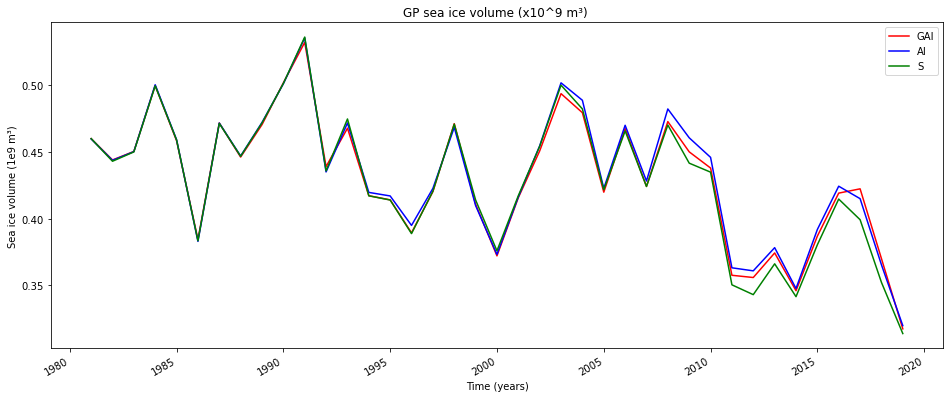

In [42]:
gp20 = [504,1098]
gp21 = [462,1175]
gpBG = [484,1111]
gpNG = [984,1199]
#print(nav_lon.isel(x=gp20[0],y=gp20[1]).values)
#print(nav_lat.isel(x=gp20[0],y=gp20[1]).values)

plt.figure(figsize=([16,6]),facecolor='white')
(Arctic_dasiVOluREF.isel(x=gpNG[0],y=gpNG[1])/1e9).plot(color='r')
(Arctic_dasiVOluAI.isel(x=gpNG[0],y=gpNG[1])/1e9).plot(color='b')
(Arctic_dasiVOlu.isel(x=gpNG[0],y=gpNG[1])/1e9).plot(color='g')
plt.legend(['GAI','AI','S'])
plt.title('GP sea ice volume (x10^9 m³) ')
plt.xlabel('Time (years)')
plt.ylabel('Sea ice volume (1e9 m³)')
plt.show()

In [8]:
#calculating the total volume
Tot_Arctic_dasiVOlu = Arctic_dasiVOlu.sum(('x','y'))
Tot_Arctic_dasiVOluREF = Arctic_dasiVOluREF.sum(('x','y'))
Tot_Arctic_dasiVOluAI = Arctic_dasiVOluAI.sum(('x','y'))

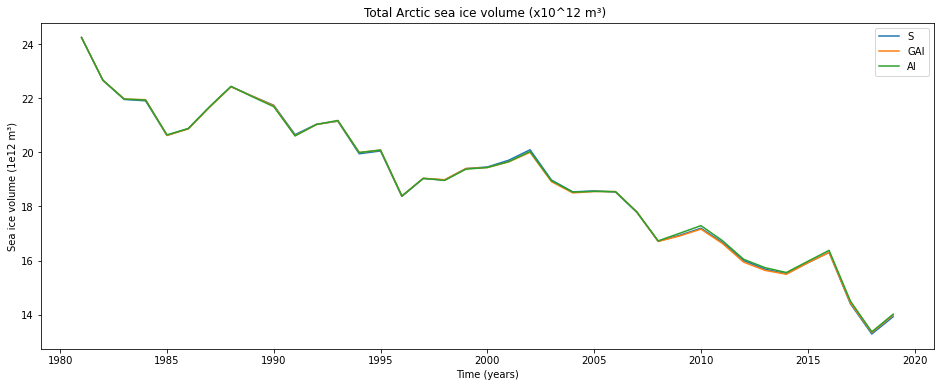

from annual data


In [20]:
# time series of totla Arctic sea ice volume for the three simulations
plt.figure(figsize=([16,6]),facecolor='white')
plt.plot(time,Tot_Arctic_dasiVOlu/1e12)
plt.plot(time,Tot_Arctic_dasiVOluREF/1e12)
plt.plot(time,Tot_Arctic_dasiVOluAI/1e12)
plt.legend(['S','GAI','AI'])
plt.title('Total Arctic sea ice volume (x10^12 m³) ')
plt.xlabel('Time (years)')
plt.ylabel('Sea ice volume (1e12 m³)')
plt.show()
print("from annual data")

# looking the the spatial variability

Seaicevolume_2001_1y_GAI.png


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


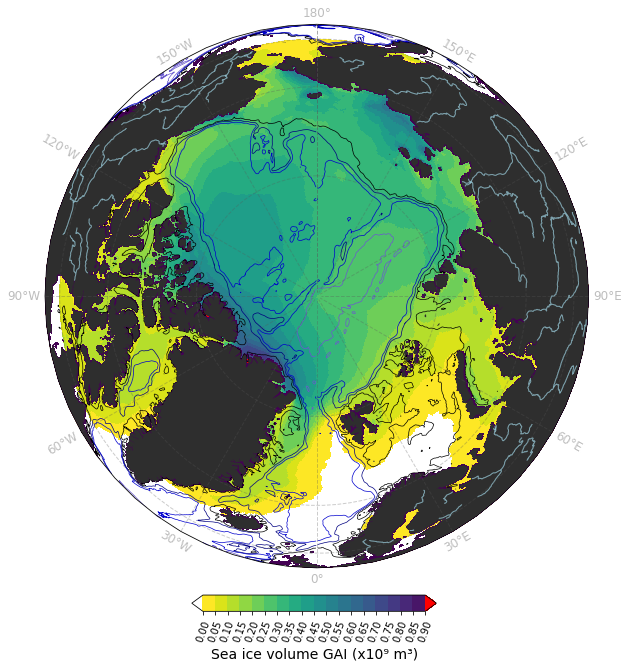

In [12]:
# Map to see sea ice volume in the Arctic
reg = 'gro'

# RUN to PLOT

#========= DATA TO PLOT
for iexp in ['nexpREF']: #'DIFFGAIAI' 'DIFFGAIS','DIFFAIS','DIFFGAIGA','DIFFGAIGI']:

    # main variable
    if iexp=='nexpREF':
        data = Arctic_dasiVOluREF.sel(time_counter='2001')/1e9
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume "+nexpREF+" (x10⁹ m³)" #" over "+y1+"-"+y2 # SSH
        namo = "Seaicevolume_2001_"+fo+"_"+nexpREF+".png"
        print(namo)


    # lat lon
    lon2plot   = nav_lon.squeeze()
    lat2plot   = nav_lat.squeeze()
    # land mask from model
    m2plt      = tmask.where(tmask==0)

    #========= Plot settings ===============
    levbounds=[0,0.95,0.05]  # varna sossheig

    # COLORMAP
    co='vi' # inferno
    #add indication of colormap to the plot name:
    #namo = co+namo

    # color for continents from data based (hi-res)
    onecohrml='#2E2E2E'

    # customed colormapls
    if (co=='in'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='inferno_r',cu='w',co='k')

    if (co=='vi'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='viridis_r',cu='w',co='r')

    if (co=='coolwarm'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='seismic',cu='midnightblue',co='darkred')

    if (co=='Spectral'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='Spectral_r',cu='w',co='r')


    # default gridlines parameters
    gridl=False
    incrgridlon=30
    incrgridlat=10


    loncentr=0
    latcentr=90
    sath=2085831


    #================================================================
    #========= CREATE FIGURE
    fig3 = plt.figure(figsize=([18,10]),facecolor='white')

    #========= PLOT DATA
    # Data system proj (if coords are in lat lon, use PlateCarre here)
    trdata  = ccrs.PlateCarree() 

    ax = plt.axes(projection= ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,
                                                       satellite_height=sath))

    cs  = plt.pcolormesh(lon2plot, lat2plot, data2plot,shading='flat',cmap=cmap,transform=trdata,norm=norm)

    # plot grey shading  where ocean mask is 0 (land gridpoints in the model)
    cs2  = plt.pcolormesh(lon2plot, lat2plot, m2plt, shading='flat',
                          transform=trdata) # cmap=slx.make_SLXcolormap(reverse=False)

    
    ##============= BATHYMETRY
    # Add 1000 and 200 meters bathymetry lines and labels. We will apply a Gaussian filter to smooth the data. 
    bathy_levels = [200,1000,2000,4000]
    color_levels= ['k','navy','mediumblue','slateblue']
    # west
    Ct1 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0),
                    bathy_levels,colors=color_levels,
                    linewidths=0.7,linestyles='solid',transform=trdata)
    # east
    Ct2 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0),
                    bathy_levels,colors=color_levels,
                    linewidths=0.7,linestyles='solid',transform=trdata)

    #========= coastlines and gridlines

    # cartopy basic options for coastlines
    #cl = ax.coastlines(color= '#BDBDBD')
    #
    # cartopy FEATURES
    rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', 
                                                 scale='50m',facecolor='none',edgecolor='b')

        #lands = cartopy.feature.NaturalEarthFeature(
        #    category='physical', name='coastline',
        #    scale='50m',facecolor='none',edgecolor='k')

    cl2 = ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor=onecohrml,edgecolor= 'none',alpha=1,zorder=5)
    clr = ax.add_feature(cartopy.feature.RIVERS,alpha=0.4,facecolor='none',edgecolor='#A9E2F3',zorder=6)
    clr2 = ax.add_feature(rivers,alpha=0.4,facecolor='none',edgecolor='#A9E2F3',zorder=6)  ##CEE3F6

    #========= GRIDLINES
    gl =ax.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
    label_style = {'size': 12, 'color': '#BDBDBD', 'weight': 'normal'}
    gl.xlabel_style = label_style
    #gl.xlabels_bottom = False
    gl.ylabel_style = label_style
    #gl.ylabels_right = False

    #========= ADD COLORBAR
    cbon=True
    if cbon:
        cb = slx.addcolorbar(fig3,cs,ax,levbounds,levincr=1,tformat="%.2f",
                            tlabel=tlabel,facmul=1,orientation='horizontal',tc='k',
                            bbta=(-0.18,-0.25,0.9,0.2))  

    #========= PLT SHOW
    plt.show()    # rgb color for model land grid points
    #slx.saveplt(fig3,diro,namo,dpifig=300)
    plt.close(fig3)

In [32]:
#mean
Arctic_dasiVOluREFmeanFP = Arctic_dasiVOluREF.mean('time_counter')
Arctic_dasiVOluREFmeanSP = Arctic_dasiVOluREF.sel(time_counter=slice('1998','2011')).mean('time_counter')

Arctic_dasiVOlumeanFP = Arctic_dasiVOlu.mean('time_counter')
Arctic_dasiVOlumeanSP = Arctic_dasiVOlu.sel(time_counter=slice('1998','2011')).mean('time_counter')

Arctic_dasiVOluAImeanFP = Arctic_dasiVOluAI.mean('time_counter')
Arctic_dasiVOluAImeanSP = Arctic_dasiVOluAI.sel(time_counter=slice('1998','2011')).mean('time_counter')

In [33]:
diff_REFmeanFP = Arctic_dasiVOluREFmeanFP - Arctic_dasiVOluAImeanFP
diff_REFmeanSP = Arctic_dasiVOluREFmeanSP - Arctic_dasiVOluAImeanSP

diff_REFmeanFPprop = ((Arctic_dasiVOluREFmeanFP - Arctic_dasiVOluAImeanFP)/Arctic_dasiVOluREFmeanFP)*100
diff_REFmeanSPprop = ((Arctic_dasiVOluREFmeanSP - Arctic_dasiVOluAImeanSP)/Arctic_dasiVOluREFmeanSP)*100

#diff_REFmeanFPprop.quantile([0,0.05,0.1,0.25,0.5,0.75,0.90,0.95,1])
#daaa = diff_REFmeanFPprop.where((diff_REFmeanFPprop>-4.75622946e+00) & \
#                         (diff_REFmeanFPprop<2.53470493e+00) ,drop=False)

In [23]:
dsss = diff_REFmeanFPprop.where((nav_lon>-152.5) & (nav_lon<-140.5) &
                            (nav_lat>72.3) & (nav_lat<77.3),drop=False)
dsss.mean()

<xarray.DataArray ()>
array(0.21547606)

In [8]:
#std
Arctic_dasiVOluREFstdFP = Arctic_dasiVOluREF.std('time_counter')
Arctic_dasiVOluREFstdSP = Arctic_dasiVOluREF.sel(time_counter=slice('1998','2011')).std('time_counter')

Arctic_dasiVOlustdFP = Arctic_dasiVOlu.std('time_counter')
Arctic_dasiVOlustdSP = Arctic_dasiVOlu.sel(time_counter=slice('1998','2011')).std('time_counter')

Arctic_dasiVOluAIstdFP = Arctic_dasiVOluAI.std('time_counter')
Arctic_dasiVOluAIstdSP = Arctic_dasiVOluAI.sel(time_counter=slice('1998','2011')).std('time_counter')

/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/pyth

(array([4.3372e+04, 3.0523e+04, 2.9115e+04, 4.3400e+03, 8.2500e+02,
        2.7800e+02, 5.7000e+01, 4.0000e+01, 8.0000e+00, 1.0000e+01]),
 array([0.        , 0.02032001, 0.04064002, 0.06096002, 0.08128003,
        0.10160004, 0.12192005, 0.14224006, 0.16256007, 0.18288007,
        0.20320008]),
 <BarContainer object of 10 artists>)

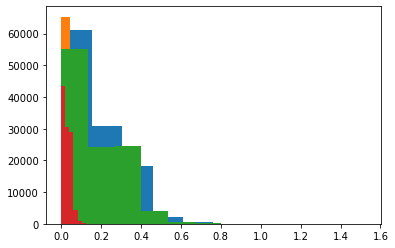

In [56]:
(Arctic_dasiVOluREFmeanFP/1e9).plot.hist()
(Arctic_dasiVOluREFstdFP/1e9).plot.hist()

(Arctic_dasiVOluREFmeanSP/1e9).plot.hist()
(Arctic_dasiVOluREFstdSP/1e9).plot.hist()

In [ ]:
(Arctic_dasiVOluREFmeanSP/1e9)/(Arctic_dasiVOluREFstdSP/1e9)

Seaicevolume_meanFP_1y_GAI.png


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


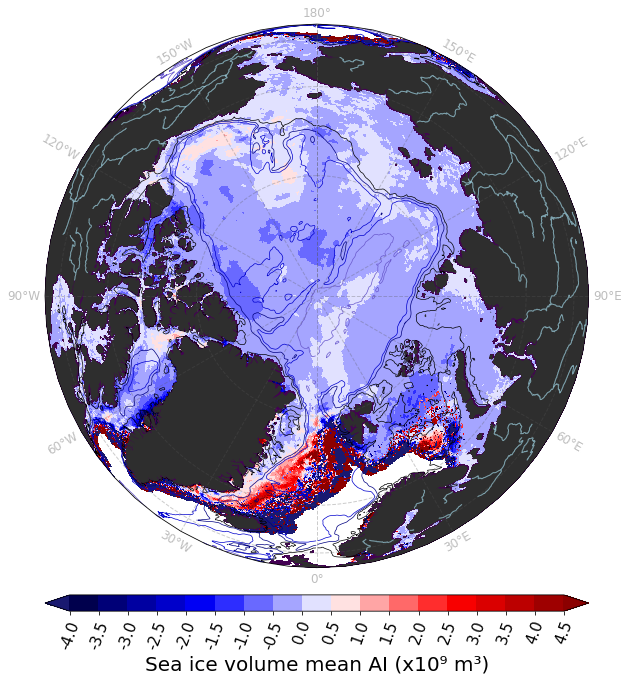

In [35]:
# Map to see sea ice volume in the Arctic
reg = 'gro'

# RUN to PLOT

#========= DATA TO PLOT
for iexp in ['nexpREF']: #'DIFFGAIAI' 'DIFFGAIS','DIFFAIS','DIFFGAIGA','DIFFGAIGI']:

    # main variable
    if iexp=='nexpREF':
        data = diff_REFmeanFPprop
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume mean "+nexpAI+" (x10⁹ m³)" #" over "+y1+"-"+y2 # SSH
        namo = "Seaicevolume_meanFP_"+fo+"_"+nexpREF+".png"
        print(namo)

    # lat lon
    lon2plot   = nav_lon.squeeze()
    lat2plot   = nav_lat.squeeze()
    # land mask from model
    m2plt      = tmask.where(tmask==0)

    #========= Plot settings ===============
    #levbounds=[0,0.55,0.05]  # varna mean
    levbounds=[-4,5,0.5]  # varna prop

    # COLORMAP
    co='coolwarm' # inferno
    #add indication of colormap to the plot name:
    #namo = co+namo

    # color for continents from data based (hi-res)
    onecohrml='#2E2E2E'

    # customed colormapls
    if (co=='in'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='inferno_r',cu='w',co='k')

    if (co=='vi'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='viridis_r',cu='w',co='r')

    if (co=='coolwarm'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='seismic',cu='midnightblue',co='darkred')

    if (co=='Spectral'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='Spectral_r',cu='w',co='r')


    # default gridlines parameters
    gridl=False
    incrgridlon=30
    incrgridlat=10


    loncentr=0
    latcentr=90
    sath=2085831


    #================================================================
    #========= CREATE FIGURE
    fig3 = plt.figure(figsize=([18,10]),facecolor='white')

    #========= PLOT DATA
    # Data system proj (if coords are in lat lon, use PlateCarre here)
    trdata  = ccrs.PlateCarree() 

    ax = plt.axes(projection= ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,
                                                       satellite_height=sath))

    cs  = plt.pcolormesh(lon2plot, lat2plot, data2plot,shading='flat',cmap=cmap,transform=trdata,norm=norm)

    # plot grey shading  where ocean mask is 0 (land gridpoints in the model)
    cs2  = plt.pcolormesh(lon2plot, lat2plot, m2plt, shading='flat',
                          transform=trdata) # cmap=slx.make_SLXcolormap(reverse=False)

    
    ##============= BATHYMETRY
    # Add 1000 and 200 meters bathymetry lines and labels. We will apply a Gaussian filter to smooth the data. 
    bathy_levels = [200,1000,2000,4000]
    color_levels= ['k','navy','mediumblue','slateblue']
    # west
    Ct1 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0),
                    bathy_levels,colors=color_levels,
                    linewidths=0.7,linestyles='solid',transform=trdata)
    # east
    Ct2 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0),
                    bathy_levels,colors=color_levels,
                    linewidths=0.7,linestyles='solid',transform=trdata)

    #========= coastlines and gridlines

    # cartopy basic options for coastlines
    #cl = ax.coastlines(color= '#BDBDBD')
    #
    # cartopy FEATURES
    rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', 
                                                 scale='50m',facecolor='none',edgecolor='b')

        #lands = cartopy.feature.NaturalEarthFeature(
        #    category='physical', name='coastline',
        #    scale='50m',facecolor='none',edgecolor='k')

    cl2 = ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor=onecohrml,edgecolor= 'none',alpha=1,zorder=5)
    clr = ax.add_feature(cartopy.feature.RIVERS,alpha=0.4,facecolor='none',edgecolor='#A9E2F3',zorder=6)
    clr2 = ax.add_feature(rivers,alpha=0.4,facecolor='none',edgecolor='#A9E2F3',zorder=6)  ##CEE3F6

    #========= GRIDLINES
    gl =ax.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
    label_style = {'size': 12, 'color': '#BDBDBD', 'weight': 'normal'}
    gl.xlabel_style = label_style
    #gl.xlabels_bottom = False
    gl.ylabel_style = label_style
    #gl.ylabels_right = False

    #========= ADD COLORBAR
    cbon=True
    if cbon:
        cb = slx.addcolorbar(fig3,cs,ax,levbounds,levincr=1,tformat="%.1f",
                            tlabel=tlabel,facmul=1,orientation='horizontal')  

    #========= PLT SHOW
    plt.show()    # rgb color for model land grid points
    #slx.saveplt(fig3,diro,namo,dpifig=300)
    plt.close(fig3)

# LOOKING in the BOXBG

## total sea ice volume in the BoxBG

In [9]:
BGdasiVOlu = dasiVOlu.where((dasiVOlu.lon>-152.5) & (dasiVOlu.lon<-140.5) &
                            (dasiVOlu.lat>72.3) & (dasiVOlu.lat<77.3),drop=True).sum(('x','y'))
BGdasiVOluREF = dasiVOluREF.where((dasiVOlu.lon>-152.5) & (dasiVOlu.lon<-140.5) &
                            (dasiVOlu.lat>72.3) & (dasiVOlu.lat<77.3),drop=True).sum(('x','y'))
BGdasiVOluAI = dasiVOluAI.where((dasiVOlu.lon>-152.5) & (dasiVOlu.lon<-140.5) &
                            (dasiVOlu.lat>72.3) & (dasiVOlu.lat<77.3),drop=True).sum(('x','y'))

In [10]:
# calculating the linear trend over the period 1998-2011
time_period = np.arange(1998,2012)

period_BGdasiVOluREF = BGdasiVOluREF.sel(time_counter=slice('1998','2011'))/1e12
period_BGdasiVOluAI = BGdasiVOluAI.sel(time_counter=slice('1998','2011'))/1e12
period_BGdasiVOlu = BGdasiVOlu.sel(time_counter=slice('1998','2011'))/1e12

Period_REFtr = np.polyfit(time_period,period_BGdasiVOluREF,1)
print( "{0}x + {1}".format(*Period_REFtr))
Period_AItr = np.polyfit(time_period,period_BGdasiVOluAI,1)
print( "{0}x + {1}".format(*Period_AItr))
Period_tr = np.polyfit(time_period,period_BGdasiVOlu,1)
print( "{0}x + {1}".format(*Period_tr))

Period_REFts = Period_REFtr[0]*time_period+ Period_REFtr[1]
Period_AIts = Period_AItr[0]*time_period+ Period_AItr[1]
Period_ts = Period_tr[0]*time_period+ Period_tr[1]

0.010384279125137336x + -20.438769333406935
0.01111403614745936x + -21.905182877241305
0.011293344075274313x + -22.252196268037267


In [43]:
# différence de pente de la trend
print('diff trend GAI-AI',Period_REFtr[0] - Period_AItr[0])
print('diff trend GAI-S',Period_REFtr[0] - Period_tr[0])
print('diff trend AI-S',Period_AItr[0] - Period_tr[0])

diff trend GAI-AI -0.0007297570223220237
diff trend GAI-S -0.0009090649501369771
diff trend AI-S -0.00017930792781495342


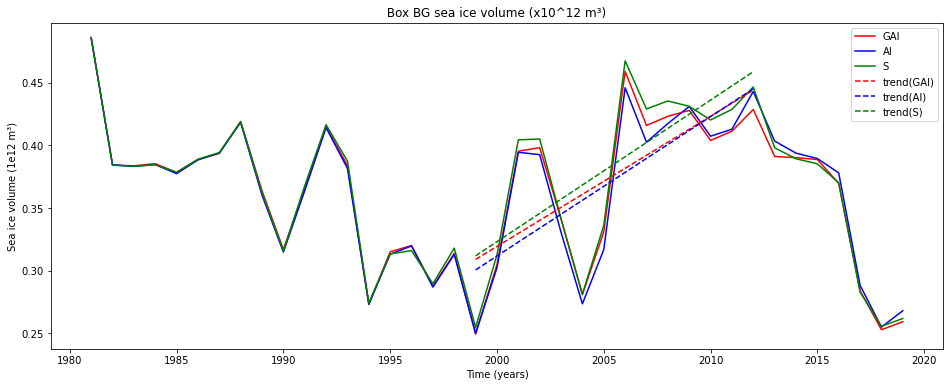

from annual data


In [41]:
# time series of totla Arctic sea ice volume for the three simulations
plt.figure(figsize=([16,6]),facecolor='white')
plt.plot(time,BGdasiVOluREF/1e12, 'r')
plt.plot(time,BGdasiVOluAI/1e12, 'b')
plt.plot(time,BGdasiVOlu/1e12, 'g')

#for the linear trend time series
time_period = pd.date_range(start=str(1998), end=str(2011+1), freq='Y')
plt.plot(time_period,Period_REFts, 'r',linestyle='--')
plt.plot(time_period,Period_AIts, 'b',linestyle='--')
plt.plot(time_period,Period_ts,'g',linestyle='--')

plt.legend(['GAI','AI','S', 'trend(GAI)','trend(AI)','trend(S)'])
plt.title(' Box BG sea ice volume (x10^12 m³) ')
plt.xlabel('Time (years)')
plt.ylabel('Sea ice volume (1e12 m³)')
plt.show()
print("from annual data")

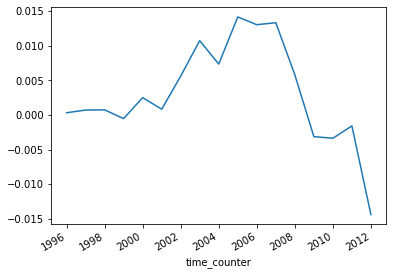

In [16]:
GAI_AI.sel(time_counter=slice('1995','2011')).plot()

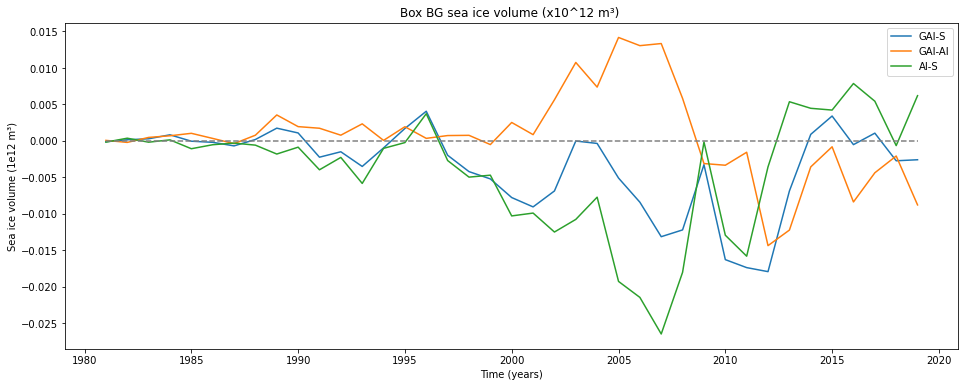

from annual data


In [17]:
# time series of totla Arctic sea ice volume for the three simulations
GAI_S = BGdasiVOluREF/1e12 - BGdasiVOlu/1e12
GAI_AI = BGdasiVOluREF/1e12 - BGdasiVOluAI/1e12
AI_S = BGdasiVOluAI/1e12 - BGdasiVOlu/1e12

plt.figure(figsize=([16,6]),facecolor='white')
plt.plot(time,GAI_S)
plt.plot(time,GAI_AI)
plt.plot(time,AI_S)

#verif de linéarité
#somme = GAI_AI + AI_S
#plt.plot(time,somme)
plt.plot(time,np.zeros(39),linestyle='--', color='grey',)
plt.legend(['GAI-S','GAI-AI','AI-S'])
plt.title('Box BG sea ice volume (x10^12 m³) ')
plt.xlabel('Time (years)')
plt.ylabel('Sea ice volume (1e12 m³)')
plt.show()
print("from annual data")

# looking at trends

In [12]:
%%time 
Arctic_dasiVOluREF = Arctic_dasiVOluREF#.sel(time_counter=slice('1998','2011')) 
Arctic_dasiVOluAI = Arctic_dasiVOluAI#.sel(time_counter=slice('1998','2011')) 
Arctic_dasiVOlu = Arctic_dasiVOlu#.sel(time_counter=slice('1998','2011')) 

DIFF_REF_S  = Arctic_dasiVOluREF - Arctic_dasiVOlu     #GAI-S
DIFF_AI_S   = Arctic_dasiVOluAI  - Arctic_dasiVOlu       #AI-S
DIFF_REF_AI = Arctic_dasiVOluREF - Arctic_dasiVOluAI   #GAI-AI
 
xrtrends_GAI,xrorigins,years, xrtrstd_GAI  = slx.trpolyfit(Arctic_dasiVOluREF,'yr')
xrtrends_AI, xrorigins,years, xrtrstd_AI   = slx.trpolyfit(Arctic_dasiVOluAI,'yr')
xrtrends_S,  xrorigins,years, xrtrstd_S    = slx.trpolyfit(Arctic_dasiVOlu,'yr')

#compute of difference
xrtrends_GAI_S, xrorigins1,years1, xrtrstd_GAI_S   = slx.trpolyfit(DIFF_REF_S,'yr')
xrtrends_GAI_AI,xrorigins2,years2, xrtrstd_GAI_AI  = slx.trpolyfit(DIFF_REF_AI,'yr')
xrtrends_AI_S,  xrorigins3,years3, xrtrstd_AI_S    = slx.trpolyfit(DIFF_AI_S,'yr')

CPU times: user 39 s, sys: 4.37 s, total: 43.3 s
Wall time: 36.7 s


(array([1.2000e+01, 2.0000e+01, 3.0000e+01, 2.7000e+02, 1.8758e+04,
        6.5412e+04, 8.6900e+03, 1.3620e+03, 9.0000e+00, 2.0000e+00]),
 array([-50.37121533, -41.7461922 , -33.12116906, -24.49614592,
        -15.87112278,  -7.24609965,   1.37892349,  10.00394663,
         18.62896977,  27.25399291,  35.87901604]),
 <BarContainer object of 10 artists>)

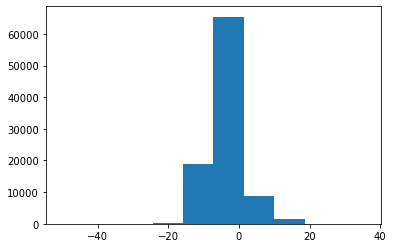

In [41]:
(xrtrends_GAI/1e6).plot.hist()

Seaicevolume_meanFP_1y_GAI.png


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


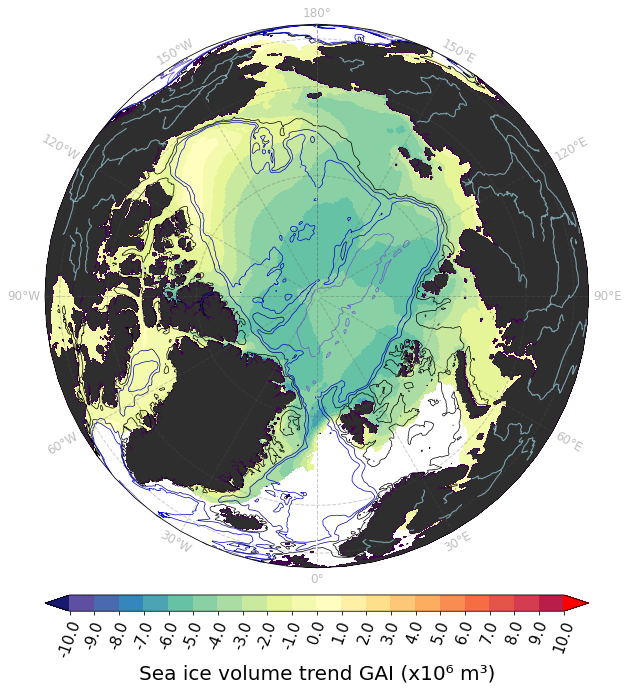

In [14]:
# Map to see sea ice volume in the Arctic
reg = 'gro'

# RUN to PLOT

#========= DATA TO PLOT
for iexp in ['nexpREF']: #'DIFFGAIAI' 'DIFFGAIS','DIFFAIS','DIFFGAIGA','DIFFGAIGI']:

    # main variable
    if iexp=='nexpREF':
        data = xrtrends_GAI/1e6
        data2plot  = data.where(tmask!=0,0 ).squeeze()
        tlabel="Sea ice volume trend "+nexpREF+" (x10⁶ m³)" #" over "+y1+"-"+y2 # SSH
        namo = "Seaicevolume_meanFP_"+fo+"_"+nexpREF+".png"
        print(namo)

    # lat lon
    lon2plot   = nav_lon.squeeze()
    lat2plot   = nav_lat.squeeze()
    # land mask from model
    m2plt      = tmask.where(tmask==0)

    #========= Plot settings ===============
    levbounds=[-5,2,0.5]  # varna exp
    #levbounds=[-2,2,0.2]  # varna diff
    levbounds=[-10,11,1]  # varna exp


    # COLORMAP
    co='Spectral' # inferno
    #add indication of colormap to the plot name:
    #namo = co+namo

    # color for continents from data based (hi-res)
    onecohrml='#2E2E2E'

    # customed colormapls
    if (co=='in'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='inferno_r',cu='w',co='k')

    if (co=='vi'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='viridis_r',cu='orange',co='r')

    if (co=='coolwarm'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='seismic',cu='midnightblue',co='darkred')

    if (co=='Spectral'):
        cmap,norm = slx.mycolormap(levbounds,cm_base='Spectral_r',cu='midnightblue',co='r')


    # default gridlines parameters
    gridl=False
    incrgridlon=30
    incrgridlat=10


    loncentr=0
    latcentr=90
    sath=2085831


    #================================================================
    #========= CREATE FIGURE
    fig3 = plt.figure(figsize=([18,10]),facecolor='white')

    #========= PLOT DATA
    # Data system proj (if coords are in lat lon, use PlateCarre here)
    trdata  = ccrs.PlateCarree() 

    ax = plt.axes(projection= ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,
                                                       satellite_height=sath))

    cs  = plt.pcolormesh(lon2plot, lat2plot, data2plot,shading='flat',cmap=cmap,transform=trdata,norm=norm)

    # plot grey shading  where ocean mask is 0 (land gridpoints in the model)
    cs2  = plt.pcolormesh(lon2plot, lat2plot, m2plt, shading='flat',
                          transform=trdata) # cmap=slx.make_SLXcolormap(reverse=False)

    
    ##============= BATHYMETRY
    # Add 1000 and 200 meters bathymetry lines and labels. We will apply a Gaussian filter to smooth the data. 
    bathy_levels = [200,1000,2000,4000]
    color_levels= ['k','navy','mediumblue','slateblue']
    # west
    Ct1 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon<0),
                    bathy_levels,colors=color_levels,
                    linewidths=0.7,linestyles='solid',transform=trdata)
    # east
    Ct2 = ax.contour(nav_lon,nav_lat,mbathy.where(nav_lon>0),
                    bathy_levels,colors=color_levels,
                    linewidths=0.7,linestyles='solid',transform=trdata)
    
    #ptsz = 5.0; ptcolor = "yellow" ; ptedge = 1.0
    #plt.plot(nav_lon.isel(x=gpBG[0],y=gpBG[1]).values, nav_lat.isel(x=gpBG[0],y=gpBG[1]).values,
    #     marker='o',markersize=ptsz, markeredgewidth=ptedge,markerfacecolor=ptcolor,
    #     markeredgecolor='black',transform=trdata) #  gp20
    
    #========= coastlines and gridlines

    # cartopy basic options for coastlines
    #cl = ax.coastlines(color= '#BDBDBD')
    #
    # cartopy FEATURES
    rivers = cartopy.feature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', 
                                                 scale='50m',facecolor='none',edgecolor='b')

        #lands = cartopy.feature.NaturalEarthFeature(
        #    category='physical', name='coastline',
        #    scale='50m',facecolor='none',edgecolor='k')

    cl2 = ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor=onecohrml,edgecolor= 'none',alpha=1,zorder=5)
    clr = ax.add_feature(cartopy.feature.RIVERS,alpha=0.4,facecolor='none',edgecolor='#A9E2F3',zorder=6)
    clr2 = ax.add_feature(rivers,alpha=0.4,facecolor='none',edgecolor='#A9E2F3',zorder=6)  ##CEE3F6

    #========= GRIDLINES
    gl =ax.gridlines(xlocs=range(-180,181,incrgridlon), ylocs=range(-90,91,incrgridlat),draw_labels=True,linewidth=1, color='#585858', alpha=0.3, linestyle='--',zorder=8)
    label_style = {'size': 12, 'color': '#BDBDBD', 'weight': 'normal'}
    gl.xlabel_style = label_style
    #gl.xlabels_bottom = False
    gl.ylabel_style = label_style
    #gl.ylabels_right = False

    #========= ADD COLORBAR
    cbon=True
    if cbon:
        cb = slx.addcolorbar(fig3,cs,ax,levbounds,levincr=1,tformat="%.1f",
                            tlabel=tlabel,facmul=1,orientation='horizontal')  

    #========= PLT SHOW
    plt.show()    # rgb color for model land grid points
    #slx.saveplt(fig3,diro,namo,dpifig=300)
    plt.close(fig3)